Importer les Bibliothèques

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay


 Chargement et Nettoyage des Données

In [7]:
# Charger le fichier CSV
data = pd.read_csv('adult.csv')

# Supprimer les colonnes inutiles
data = data.drop(['fnlwgt', 'educational-num', 'relationship', 'race', 'native-country'], axis=1)

# Remplacer les valeurs manquantes
data = data.replace(' ?', np.nan).dropna()

# Vérification des colonnes et types de données
print(data.columns)
print(data.dtypes)

# Vérification de l’équilibre des classes
print(data['income'].value_counts())


Index(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'income'],
      dtype='object')
age                int64
workclass         object
education         object
marital-status    object
occupation        object
gender            object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
income            object
dtype: object
income
<=50K    37155
>50K     11687
Name: count, dtype: int64


Gestion du Déséquilibre avec Sous-échantillonnage

In [10]:
# Séparer les classes
more_income = data[data['income'] == '>50K']
less_income = data[data['income'] == '<=50K']

# Équilibrer les classes avec sous-échantillonnage
less_income = less_income.sample(len(more_income), random_state=42)
data_under = pd.concat([more_income, less_income])

# Vérification de l'équilibre
print(data_under['income'].value_counts())


income
>50K     11687
<=50K    11687
Name: count, dtype: int64


Préparation des Données

In [13]:
# Séparer les variables indépendantes et la variable cible
X = data_under.drop(['income'], axis=1)
y = data_under['income'].map({'>50K': 1, '<=50K': 0})

# Définir les colonnes catégoriques et numériques
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64"]).columns.tolist()

# Préprocesseur pour l'encodage et la normalisation
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)


Création du Pipeline et Entraînement du Modèle

In [16]:
# Créer un pipeline avec GradientBoostingClassifier
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42)),
])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Entraîner le modèle et effectuer une validation croisée
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Afficher la précision moyenne de la validation croisée
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


Mean Cross-Validation Accuracy: 0.8330


Évaluation du Modèle avec les Métriques

In [19]:
# Générer un rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculer les métriques supplémentaires
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC-ROC: {auc:.2f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2369
           1       0.81      0.87      0.84      2306

    accuracy                           0.83      4675
   macro avg       0.84      0.83      0.83      4675
weighted avg       0.84      0.83      0.83      4675

Precision: 0.81
Recall: 0.87
AUC-ROC: 0.92


Visualisation : Matrice de Confusion et Courbe ROC

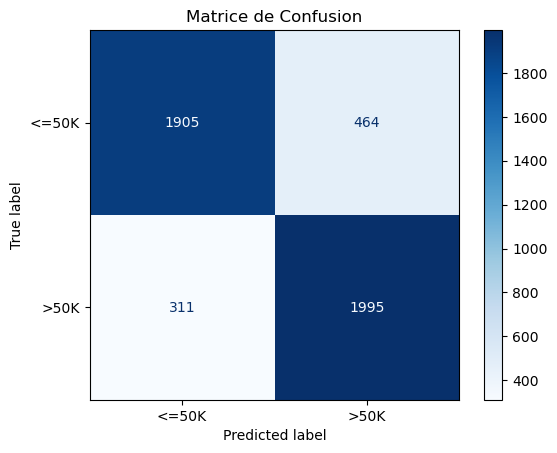

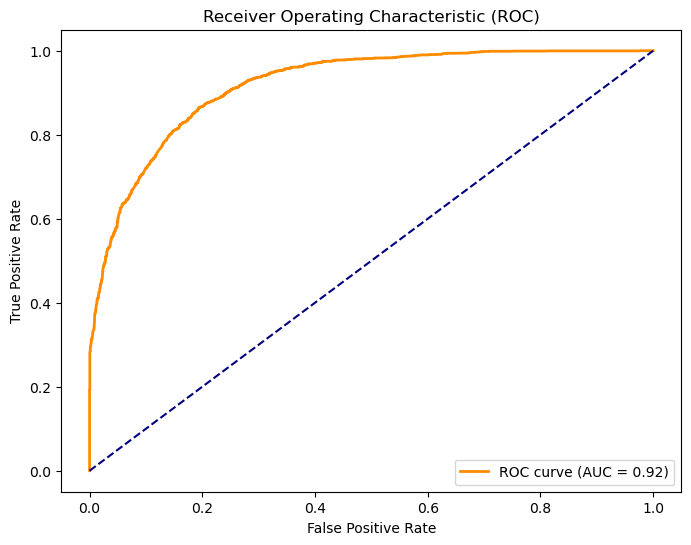

In [26]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K']).plot(cmap='Blues')
plt.title('Matrice de Confusion')
plt.show()

# Tracer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
